## Library

In [1]:
import math
import dill
import random
import numpy as np
import squigglepy as sq
from squigglepy.numbers import K

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint

exec(open('utils.py').read())
print('Loaded')

exec(open('modules/anchors.py').read())
print('Loaded')

%matplotlib inline

Loaded
Loaded


## Human brain (log FLOP/s)

In [2]:
# https://www.openphilanthropy.org/research/how-much-computational-power-does-it-take-to-match-the-human-brain/
# https://www.metaculus.com/questions/2646/what-will-the-necessary-computational-power-to-replicate-human-mental-capability-turn-out-to-be/
human_brain = sq.mixture([[0.5, sq.lognorm(13, 17, credibility=80)],
                          [0.5, sq.lognorm(13, 24, credibility=80)]])
sq.get_percentiles(human_brain @ 10000, digits=1)

{1: 10.8,
 5: 12.3,
 10: 13.0,
 20: 13.8,
 30: 14.4,
 40: 15.0,
 50: 15.6,
 60: 16.4,
 70: 17.3,
 80: 18.9,
 90: 21.6,
 95: 24.0,
 99: 28.2}

Simple lifetime
{1: 19.9,
 5: 21.3,
 10: 22.0,
 20: 22.8,
 30: 23.5,
 40: 24.0,
 50: 24.7,
 60: 25.4,
 70: 26.4,
 80: 27.8,
 90: 30.6,
 95: 33.0,
 99: 38.0}
-
GPT2 (~21 log FLOP) can do it: 3.7%
GPT3 (~23 log FLOP) can do it: 22.6%
GPT4 (~25 log FLOP) can do it: 54.8%
GPT5 (~27 log FLOP) can do it: 75.4%
-


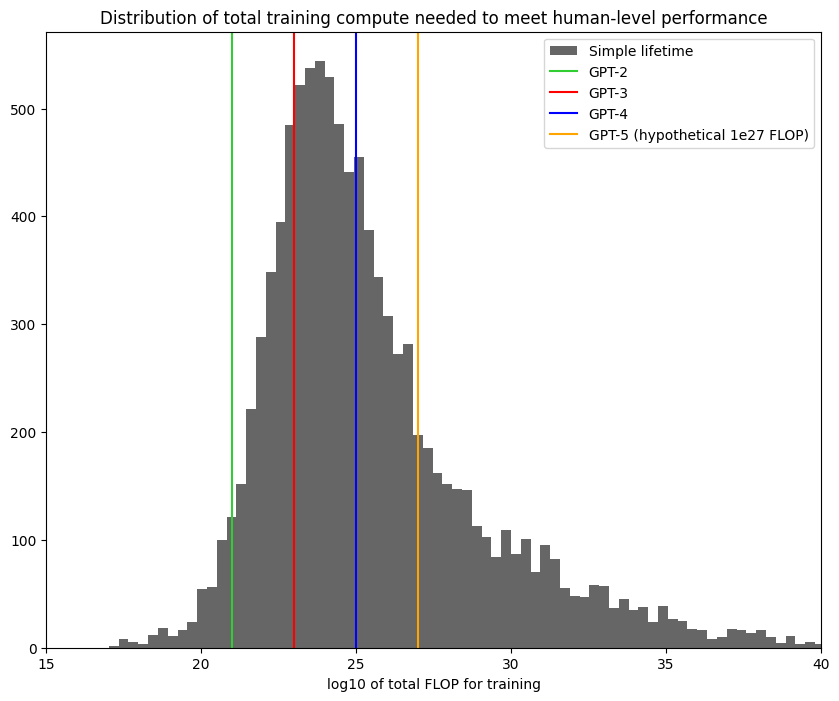

In [3]:
thirty_years_in_seconds = 30 * 365 * 24 * 60 * 60

simple_lifetime_anchor = tai_log_flop_needs(brain=human_brain,
                                            horizon_length=np.log10(thirty_years_in_seconds),
                                            ref_params=0,
                                            ref_params_samples=0,
                                            bayes_update=None)

plot_anchors(anchor1=simple_lifetime_anchor @ 10000,
             label1='Simple lifetime',
             anchor2=21,
             label2='GPT-2',
             anchor3=23,
             label3='GPT-3',
             anchor4=25,
             label4='GPT-4',
             anchor5=27,
             label5='GPT-5 (hypothetical 1e27 FLOP)',
             disable_ci_lines=True,
             xlim=[15,40])

Simple lifetime
{1: 19.6,
 5: 21.2,
 10: 21.9,
 20: 22.8,
 30: 23.4,
 40: 24.0,
 50: 24.6,
 60: 25.4,
 70: 26.3,
 80: 27.8,
 90: 30.6,
 95: 33.2,
 99: 37.9}
-
GPT2 (~21 log FLOP) can do it: 4.0%
GPT3 (~23 log FLOP) can do it: 23.0%
GPT4 (~25 log FLOP) can do it: 55.0%
GPT5 (~27 log FLOP) can do it: 75.3%
-
Cotra lifetime
{1: 25.3,
 5: 26.2,
 10: 26.6,
 20: 27.2,
 30: 27.6,
 40: 28.0,
 50: 28.5,
 60: 29.0,
 70: 29.8,
 80: 31.4,
 90: 33.8,
 95: 36.4,
 99: 41.3}
-
GPT2 (~21 log FLOP) can do it: <0.1%
GPT3 (~23 log FLOP) can do it: <0.1%
GPT4 (~25 log FLOP) can do it: 0.3%
GPT5 (~27 log FLOP) can do it: 14.2%
-


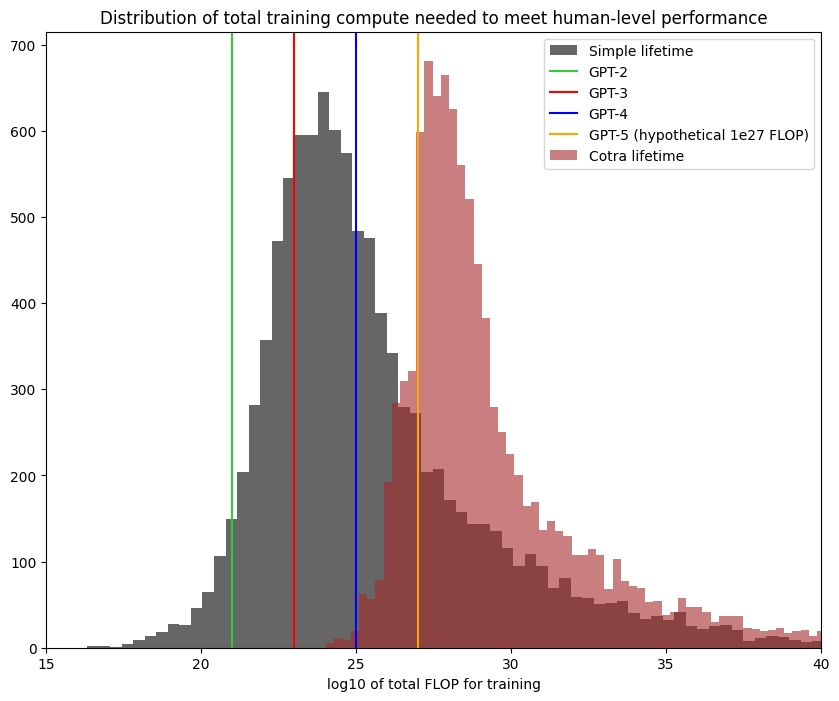

In [4]:
cotra_lifetime_anchor = tai_log_flop_needs(brain=human_brain,
                                           efficiency=sq.lognorm(2,5),
                                           horizon_length=9,
                                           ref_params=0,
                                           ref_params_samples=0,
                                           bayes_update=cotra_bayes_update_against_low_flop)


plot_anchors(anchor1=simple_lifetime_anchor @ 10000,
             label1='Simple lifetime',
             anchor2=21,
             label2='GPT-2',
             anchor3=23,
             label3='GPT-3',
             anchor4=25,
             label4='GPT-4',
             anchor5=27,
             label5='GPT-5 (hypothetical 1e27 FLOP)',
             anchor6=cotra_lifetime_anchor @ 10000,
             label6='Cotra lifetime',
             disable_ci_lines=True,
             xlim=[15,40])

## Cotra's Short NN Anchor

Short NN
{1: 25.3,
 5: 26.5,
 10: 27.2,
 20: 28.2,
 30: 29.2,
 40: 30.5,
 50: 31.7,
 60: 32.9,
 70: 34.3,
 80: 36.0,
 90: 38.4,
 95: 40.3,
 99: 44.3}
-
GPT2 (~21 log FLOP) can do it: <0.1%
GPT3 (~23 log FLOP) can do it: <0.1%
GPT4 (~25 log FLOP) can do it: 0.6%
GPT5 (~27 log FLOP) can do it: 8.0%
-


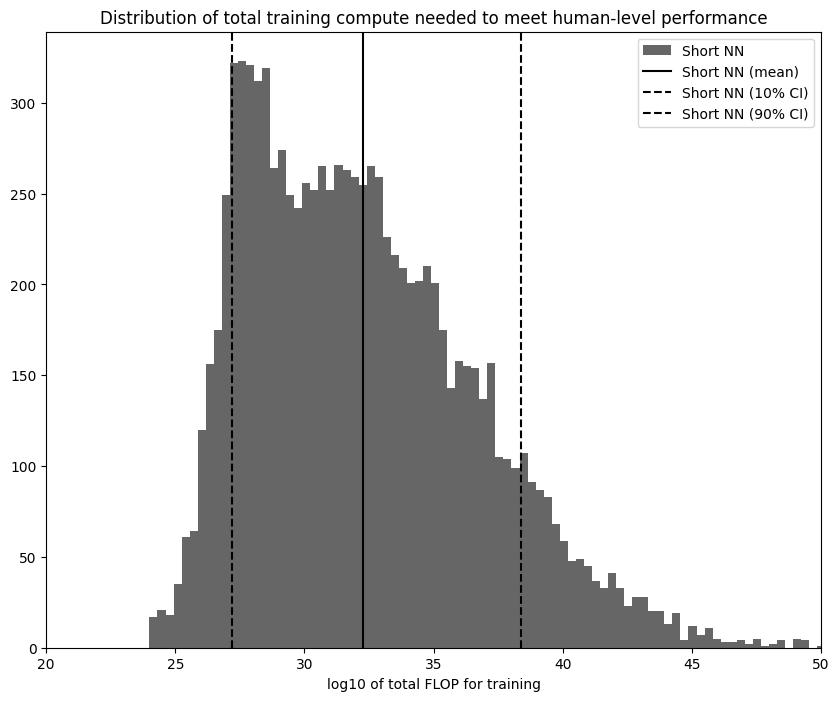

In [5]:
short_horizon_nn_anchor = cotra_anchor(horizon_length=sq.norm(0,3))
plot_anchors(short_horizon_nn_anchor @ 10000, xlim=[20, 50], label1='Short NN')

Cotra's Short NN, Before update
{1: 21.1,
 5: 24.1,
 10: 25.7,
 20: 27.8,
 30: 29.3,
 40: 30.6,
 50: 31.9,
 60: 33.0,
 70: 34.4,
 80: 36.0,
 90: 38.4,
 95: 40.3,
 99: 44.3}
-
GPT2 (~21 log FLOP) can do it: 1.0%
GPT3 (~23 log FLOP) can do it: 2.8%
GPT4 (~25 log FLOP) can do it: 7.5%
GPT5 (~27 log FLOP) can do it: 15.6%
-
Cotra's Short NN, After update
{1: 25.3,
 5: 26.4,
 10: 27.2,
 20: 28.1,
 30: 29.2,
 40: 30.4,
 50: 31.7,
 60: 33.0,
 70: 34.4,
 80: 36.1,
 90: 38.5,
 95: 40.6,
 99: 44.8}
-
GPT2 (~21 log FLOP) can do it: <0.1%
GPT3 (~23 log FLOP) can do it: <0.1%
GPT4 (~25 log FLOP) can do it: 0.6%
GPT5 (~27 log FLOP) can do it: 8.0%
-


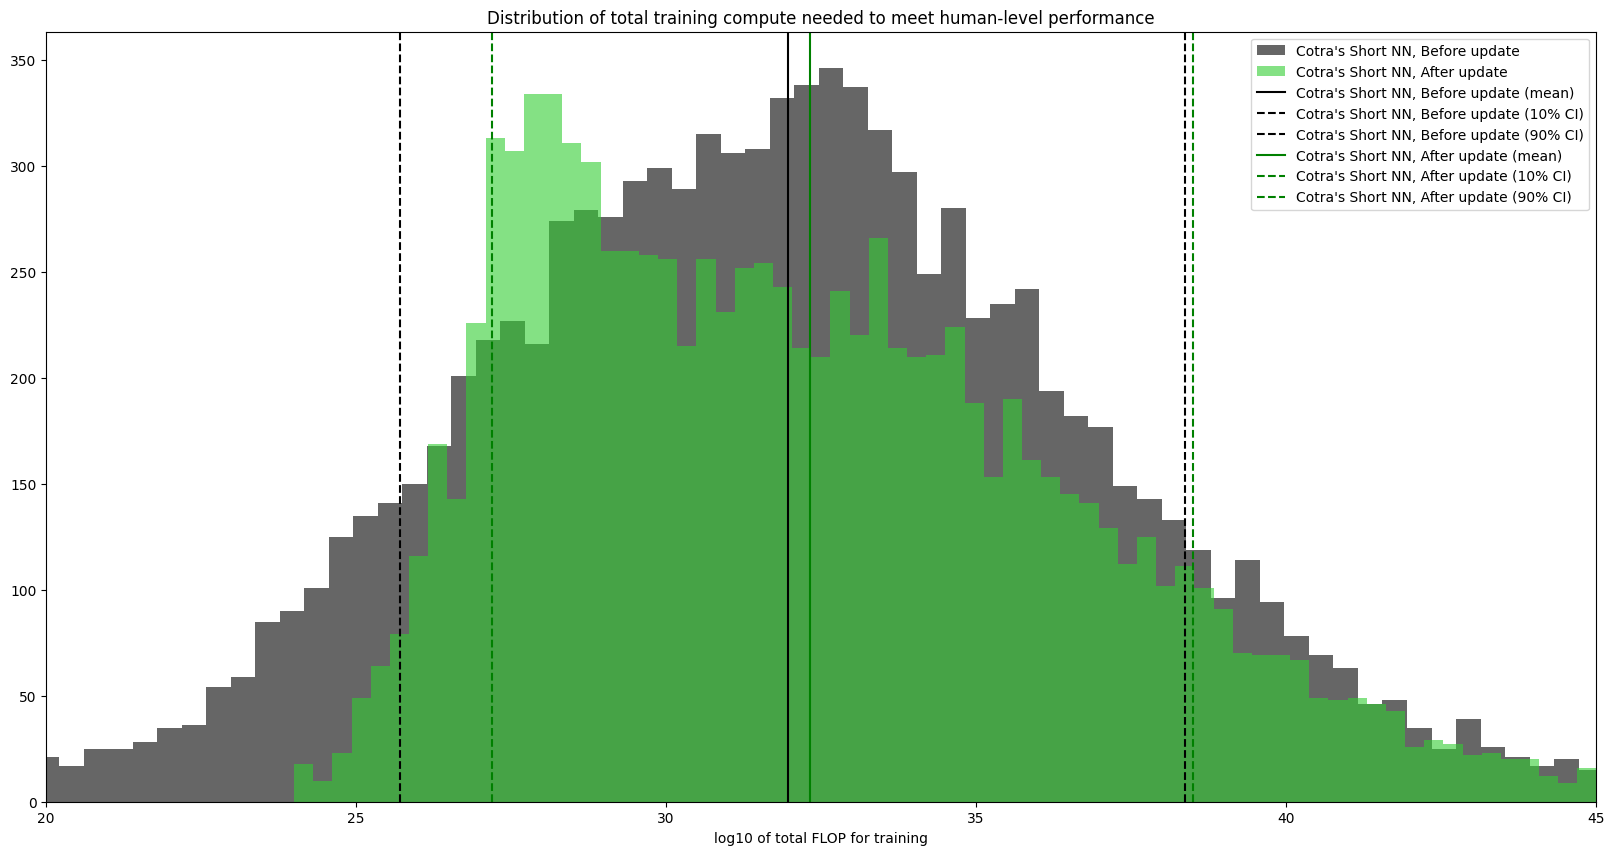

In [6]:
short_no_update = cotra_anchor(horizon_length=sq.norm(0,3), bayes_update=None)
plot_anchors(short_no_update @ 10000,
             short_horizon_nn_anchor @ 10000,
             label1='Cotra\'s Short NN, Before update',
             label2='Cotra\'s Short NN, After update',
             xlim=[20, 45],
             figsize=(20, 10))

## Cotra's Medium NN Anchor

Medium NN
{1: 26.4,
 5: 27.7,
 10: 28.8,
 20: 30.7,
 30: 32.2,
 40: 33.5,
 50: 34.7,
 60: 36.0,
 70: 37.3,
 80: 39.1,
 90: 41.4,
 95: 43.4,
 99: 47.1}
-
GPT2 (~21 log FLOP) can do it: <0.1%
GPT3 (~23 log FLOP) can do it: <0.1%
GPT4 (~25 log FLOP) can do it: 0.1%
GPT5 (~27 log FLOP) can do it: 2.0%
-


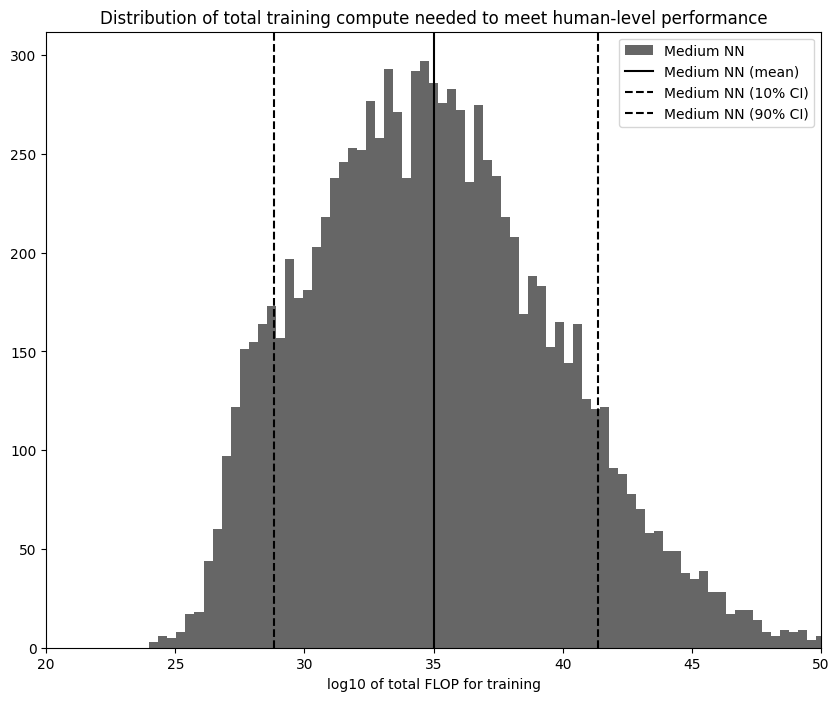

In [7]:
medium_horizon_nn_anchor = cotra_anchor(horizon_length=sq.norm(3,6))
plot_anchors(medium_horizon_nn_anchor @ 10000, xlim=[20, 50], label1='Medium NN')

## Cotra's Long NN Anchor

Long NN
{1: 27.7,
 5: 30.1,
 10: 31.7,
 20: 33.7,
 30: 35.1,
 40: 36.4,
 50: 37.6,
 60: 38.9,
 70: 40.4,
 80: 42.1,
 90: 44.3,
 95: 46.3,
 99: 50.0}
-
GPT2 (~21 log FLOP) can do it: <0.1%
GPT3 (~23 log FLOP) can do it: <0.1%
GPT4 (~25 log FLOP) can do it: <0.1%
GPT5 (~27 log FLOP) can do it: 0.3%
-


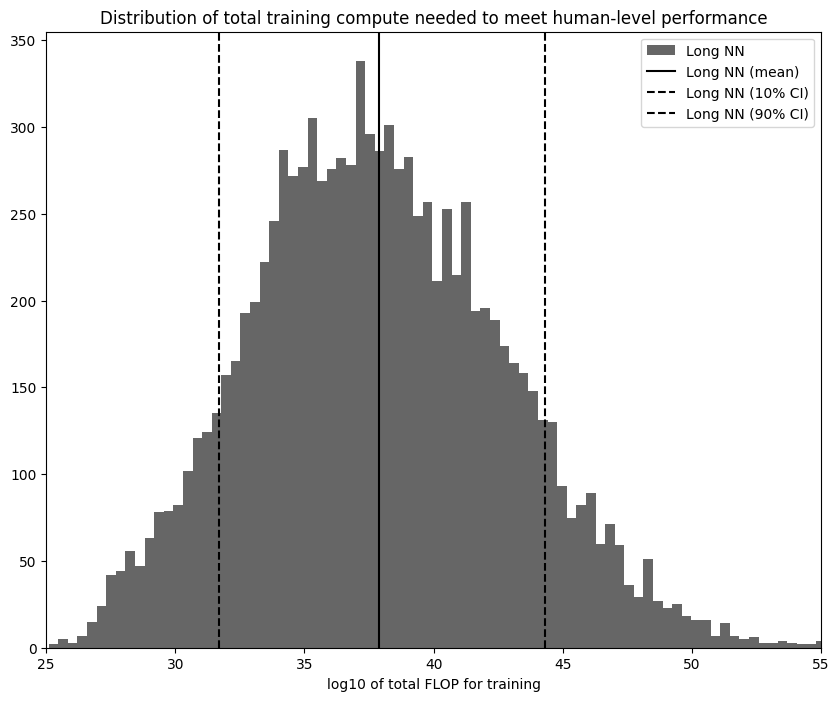

In [8]:
long_horizon_nn_anchor = cotra_anchor(horizon_length=sq.norm(6,9))
plot_anchors(long_horizon_nn_anchor @ 10000, xlim=[25, 55], label1='Long NN')

## Cotra's GPT Anchor

GPT NN
{1: 24.7,
 5: 26.0,
 10: 26.5,
 20: 27.4,
 30: 28.1,
 40: 29.0,
 50: 30.2,
 60: 31.4,
 70: 32.8,
 80: 34.5,
 90: 36.8,
 95: 38.7,
 99: 43.1}
-
GPT2 (~21 log FLOP) can do it: <0.1%
GPT3 (~23 log FLOP) can do it: <0.1%
GPT4 (~25 log FLOP) can do it: 1.5%
GPT5 (~27 log FLOP) can do it: 14.0%
-


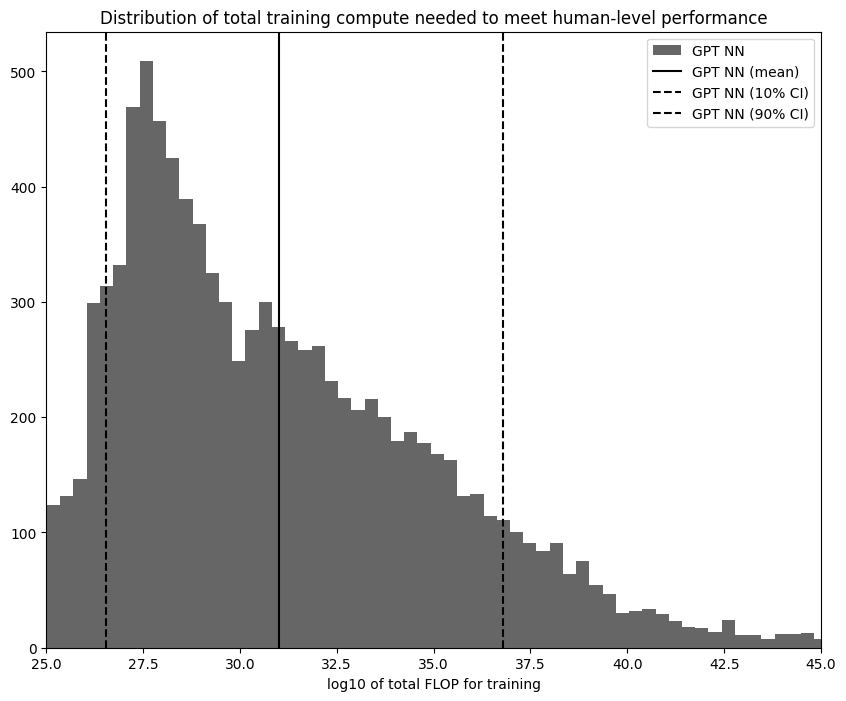

In [9]:
gpt_anchor = cotra_anchor(horizon_length=0)
plot_anchors(gpt_anchor @ 10000, xlim=[25, 45], label1='GPT NN')

Cotra's GPT NN, Before update
{1: 19.9,
 5: 22.7,
 10: 24.4,
 20: 26.3,
 30: 27.8,
 40: 29.1,
 50: 30.3,
 60: 31.5,
 70: 32.9,
 80: 34.5,
 90: 36.9,
 95: 38.7,
 99: 42.5}
-
GPT2 (~21 log FLOP) can do it: 1.8%
GPT3 (~23 log FLOP) can do it: 5.6%
GPT4 (~25 log FLOP) can do it: 12.4%
GPT5 (~27 log FLOP) can do it: 24.3%
-
Cotra's GPT NN, After update
{1: 24.7,
 5: 26.0,
 10: 26.6,
 20: 27.5,
 30: 28.3,
 40: 29.1,
 50: 30.2,
 60: 31.5,
 70: 32.8,
 80: 34.5,
 90: 36.8,
 95: 38.7,
 99: 42.5}
-
GPT2 (~21 log FLOP) can do it: <0.1%
GPT3 (~23 log FLOP) can do it: <0.1%
GPT4 (~25 log FLOP) can do it: 1.4%
GPT5 (~27 log FLOP) can do it: 13.1%
-


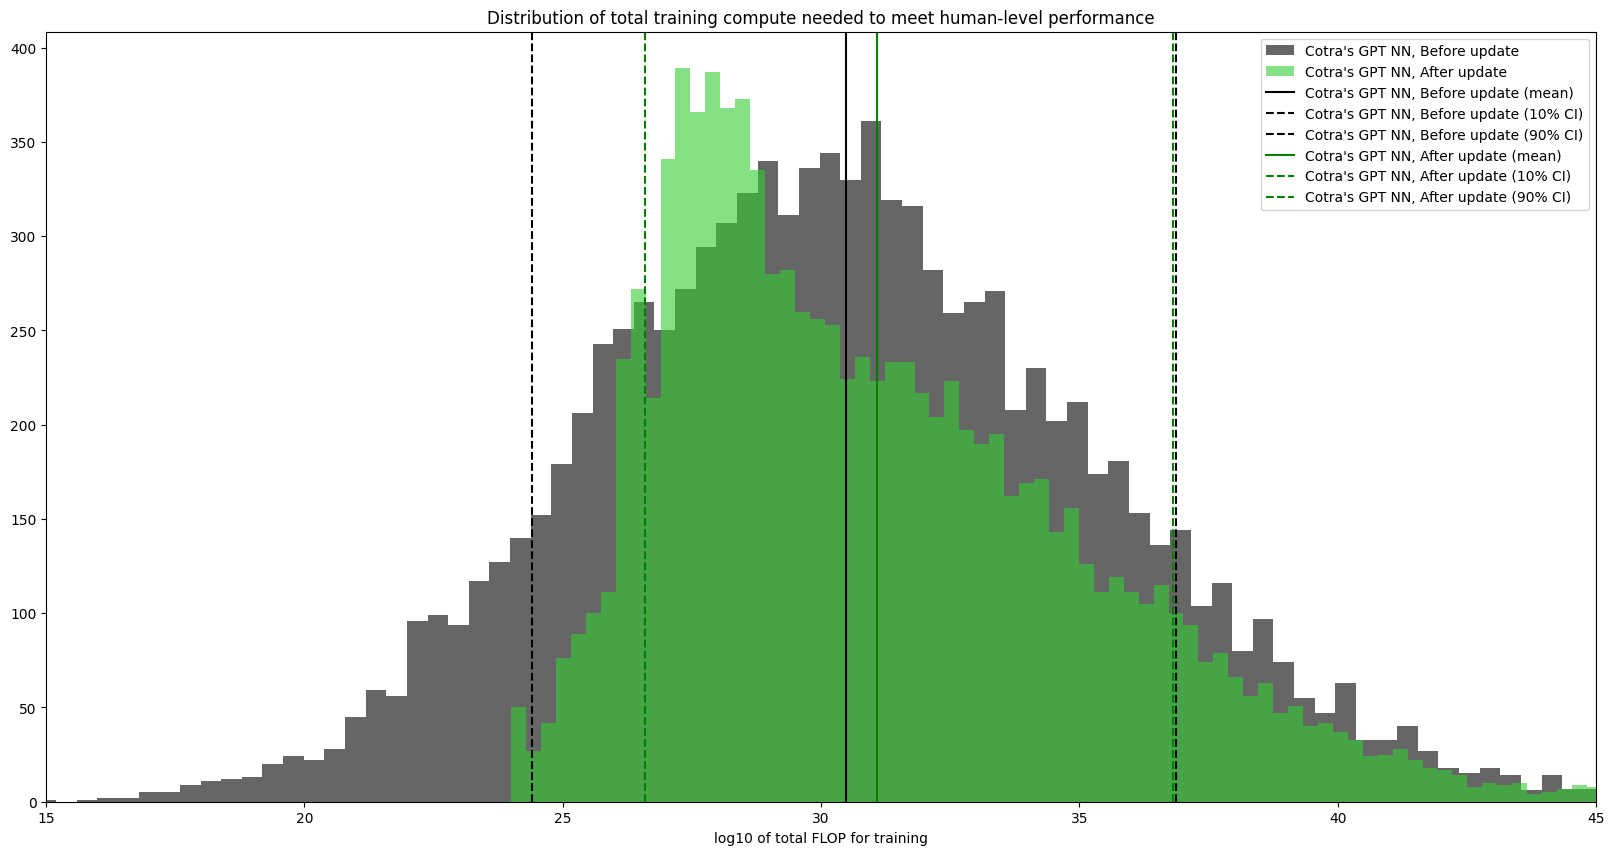

In [10]:
gpt_no_update = cotra_anchor(horizon_length=0, bayes_update=None)
plot_anchors(gpt_no_update @ 10000,
             gpt_anchor @ 10000,
             label1='Cotra\'s GPT NN, Before update',
             label2='Cotra\'s GPT NN, After update',
             xlim=[15, 45],
             figsize=(20, 10))

## Cotra's Lifetime Anchor

## Cotra's Evolution Anchor

Evolution
{1: 32.2,
 5: 34.7,
 10: 36.1,
 20: 37.7,
 30: 38.9,
 40: 39.9,
 50: 40.8,
 60: 41.8,
 70: 42.8,
 80: 44.0,
 90: 45.7,
 95: 47.0,
 99: 49.6}
-
GPT2 (~21 log FLOP) can do it: <0.1%
GPT3 (~23 log FLOP) can do it: <0.1%
GPT4 (~25 log FLOP) can do it: <0.1%
GPT5 (~27 log FLOP) can do it: <0.1%
-


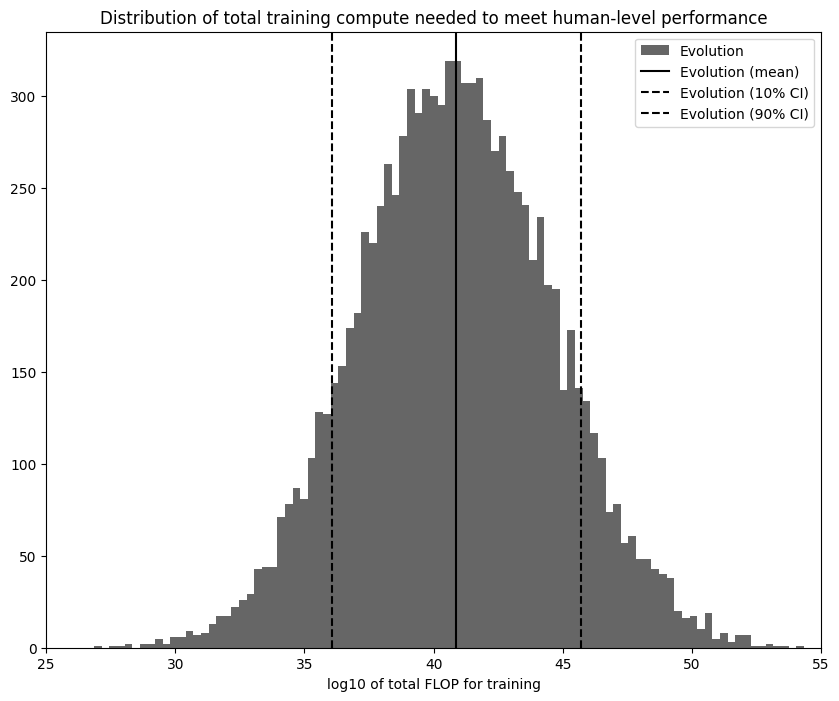

In [11]:
average_ancestor_brain_flops = sq.lognorm(3,6)
log_n_individuals = sq.norm(20,22)
evo_time_log_sec = 16
evolution_anchor = tai_log_flop_needs(brain=average_ancestor_brain_flops,
                                      efficiency=sq.norm(-6,5), # TODO: This seems not quite right
                                      transformative_vs_human=sq.norm(-2,2),
                                      horizon_length=log_n_individuals + evo_time_log_sec,
                                      scaling_exponent=0,
                                      flops_per_param_per_sec=0,
                                      ref_params_samples=0,
                                      bayes_update=None)
plot_anchors(evolution_anchor @ 10000, xlim=[25, 55], label1='Evolution')


## Cotra's Genome Anchor

Genome
{1: 26.8,
 5: 28.0,
 10: 28.9,
 20: 30.5,
 30: 31.7,
 40: 32.7,
 50: 33.8,
 60: 34.8,
 70: 35.9,
 80: 37.2,
 90: 39.0,
 95: 40.8,
 99: 43.6}
-
GPT2 (~21 log FLOP) can do it: <0.1%
GPT3 (~23 log FLOP) can do it: <0.1%
GPT4 (~25 log FLOP) can do it: <0.1%
GPT5 (~27 log FLOP) can do it: 1.2%
-


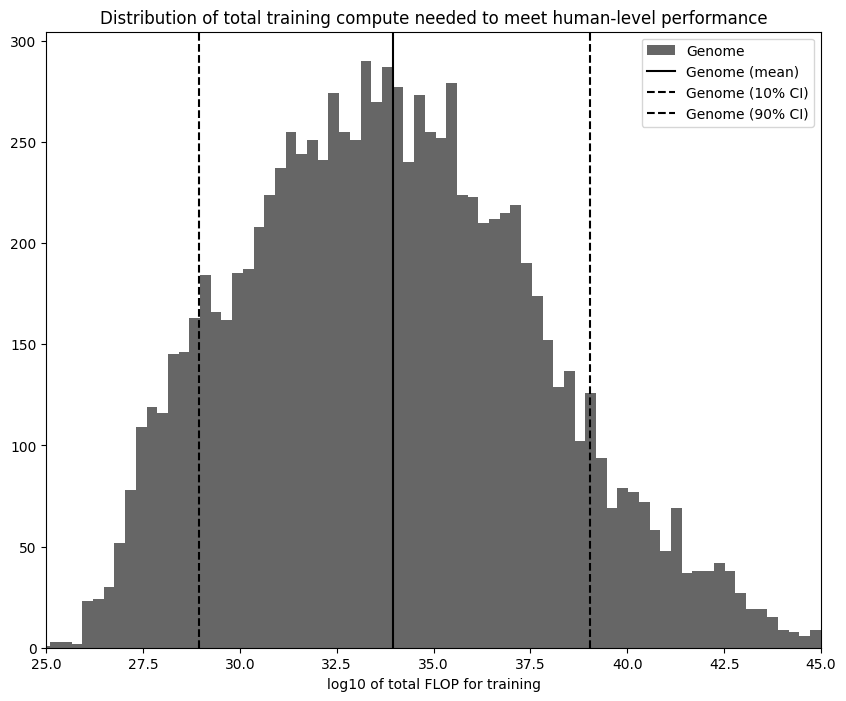

In [12]:
genome_anchor = tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                   params=sq.norm(mean=8.7, sd=0.35), # There are ~10^8.7 'params' in genome
                                   efficiency=sq.norm(0,2),
                                   transformative_vs_human=sq.norm(-2,2),
                                   horizon_length=sq.norm(7,9),
                                   scaling_exponent=sq.norm(0.5,1.1),
                                   flops_per_param_per_sec=sq.norm(1,2),
                                   bayes_update=cotra_bayes_update_against_low_flop)
plot_anchors(genome_anchor @ 10000, xlim=[25, 45], label1='Genome')


## Chinchilla Scaling Law Update

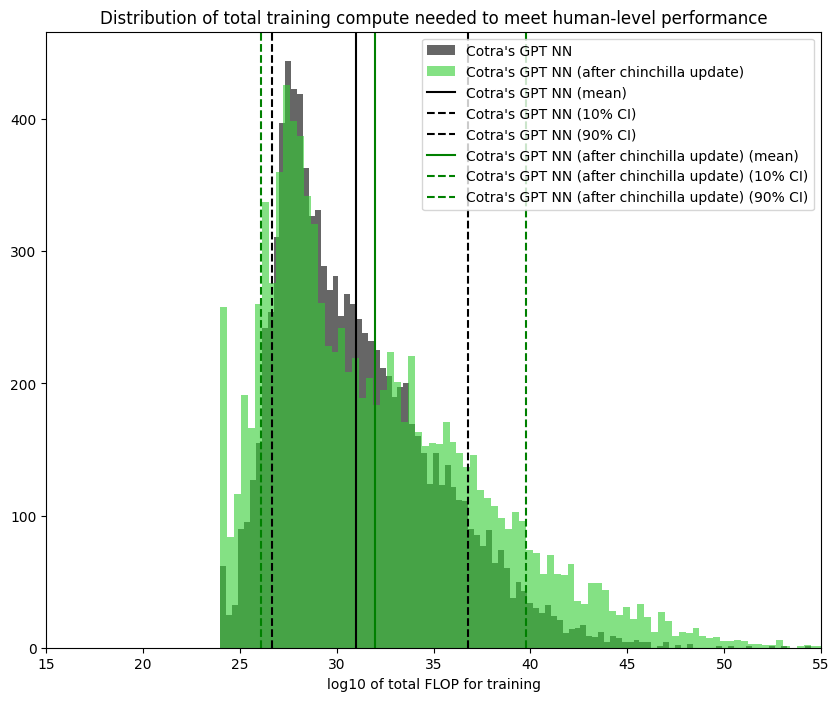

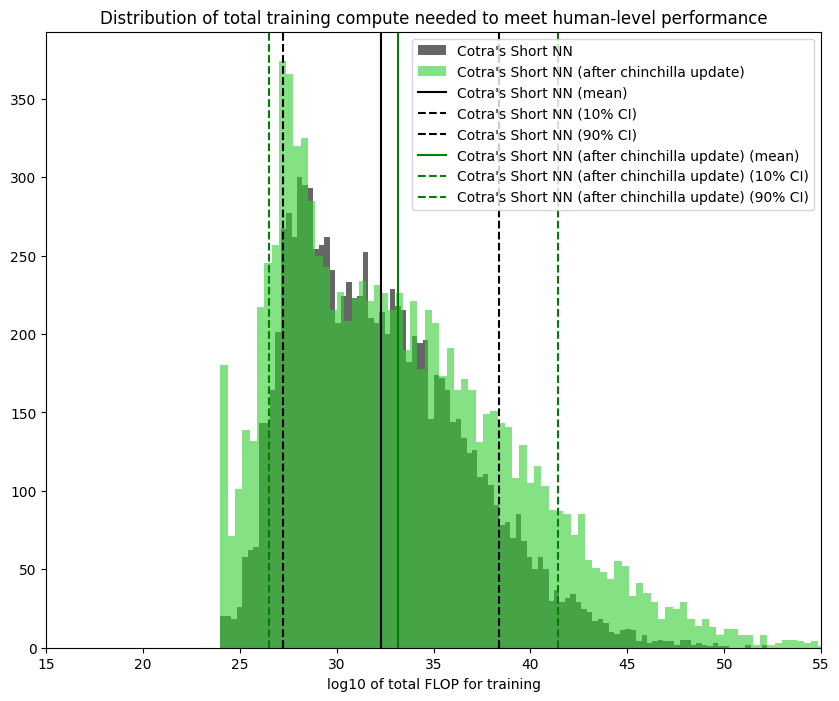

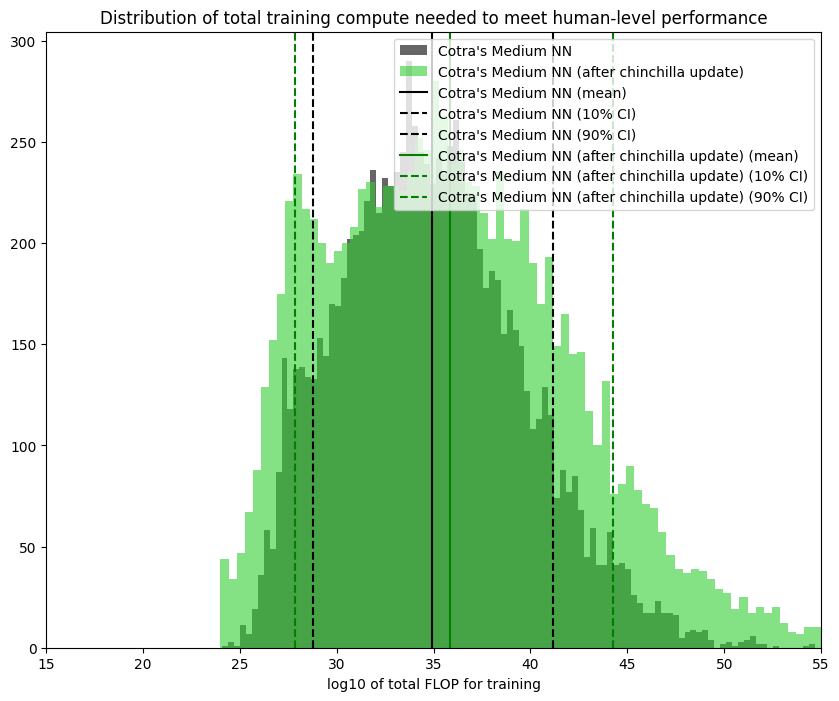

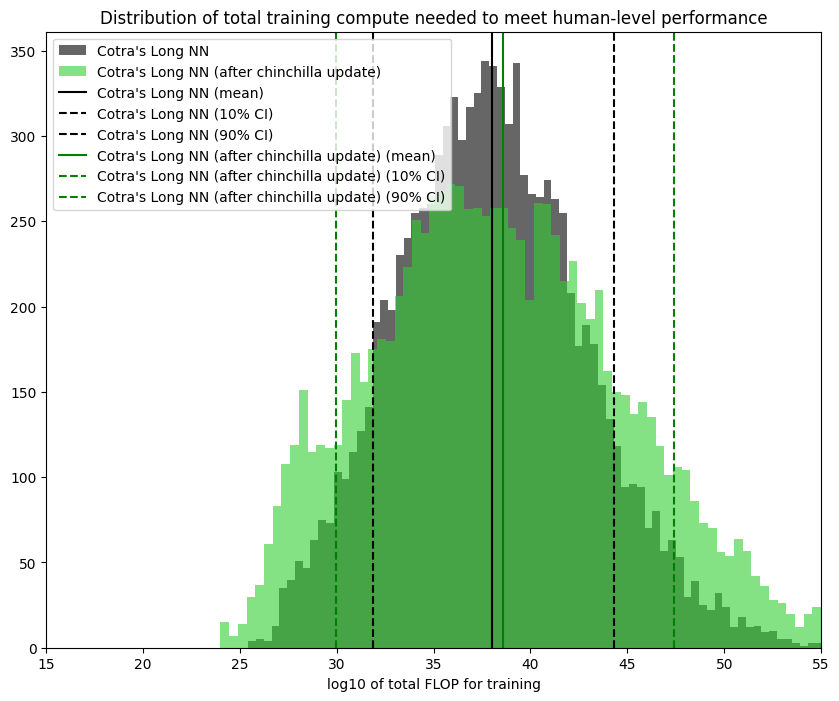

In [13]:
gpt_anchor_chinchilla = cotra_anchor(horizon_length=0, chinchilla=True)
short_horizon_nn_anchor_chinchilla = cotra_anchor(horizon_length=sq.norm(0,3), chinchilla=True)
medium_horizon_nn_anchor_chinchilla = cotra_anchor(horizon_length=sq.norm(3,6), chinchilla=True)
long_horizon_nn_anchor_chinchilla = cotra_anchor(horizon_length=sq.norm(6,9), chinchilla=True)

for anchors in [[gpt_anchor @ 10000, gpt_anchor_chinchilla @ 10000, 'Cotra\'s GPT NN'],
                [short_horizon_nn_anchor @ 10000, short_horizon_nn_anchor_chinchilla @ 10000, 'Cotra\'s Short NN'],
                [medium_horizon_nn_anchor @ 10000, medium_horizon_nn_anchor_chinchilla @ 10000, 'Cotra\'s Medium NN'],
                [long_horizon_nn_anchor @ 10000, long_horizon_nn_anchor_chinchilla @ 10000, 'Cotra\'s Long NN']]:
    plot_anchors(anchors[0],
                 anchors[1],
                 label1=anchors[2],
                 label2=anchors[2] + ' (after chinchilla update)',
                 xlim=[15, 55],
                 verbose=False)

## Updated Evolution Anchor

Cotra's evolution anchor
{1: 32.0,
 5: 34.5,
 10: 36.0,
 20: 37.7,
 30: 38.9,
 40: 39.8,
 50: 40.8,
 60: 41.7,
 70: 42.8,
 80: 44.0,
 90: 45.6,
 95: 47.0,
 99: 49.4}
-
GPT2 (~21 log FLOP) can do it: <0.1%
GPT3 (~23 log FLOP) can do it: <0.1%
GPT4 (~25 log FLOP) can do it: <0.1%
GPT5 (~27 log FLOP) can do it: <0.1%
-
Updated evolution anchor
{1: 32.3,
 5: 34.9,
 10: 36.3,
 20: 38.0,
 30: 39.2,
 40: 40.2,
 50: 41.2,
 60: 42.3,
 70: 43.4,
 80: 44.6,
 90: 46.5,
 95: 48.0,
 99: 50.8}
-
GPT2 (~21 log FLOP) can do it: <0.1%
GPT3 (~23 log FLOP) can do it: <0.1%
GPT4 (~25 log FLOP) can do it: <0.1%
GPT5 (~27 log FLOP) can do it: <0.1%
-


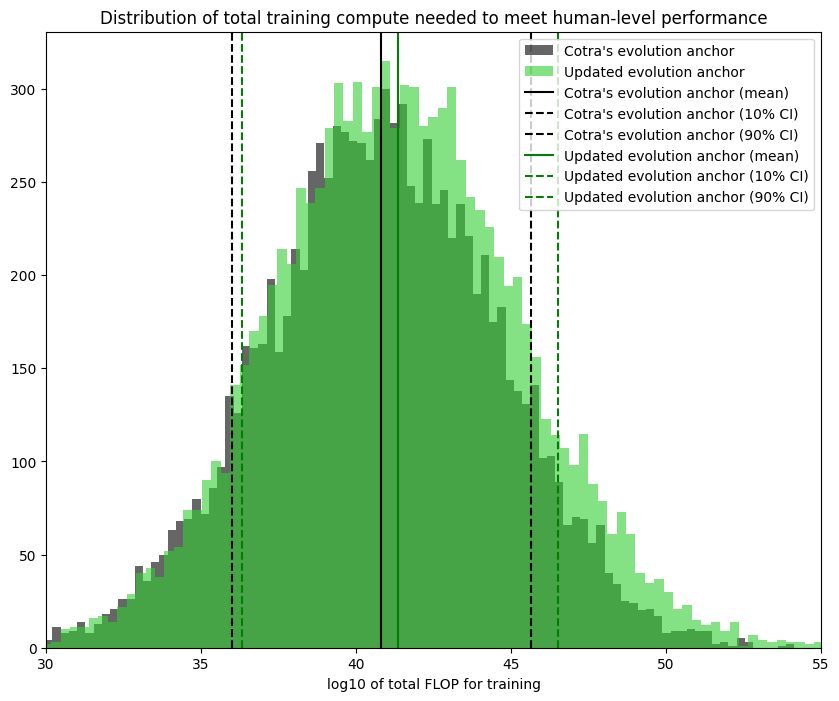

In [14]:
anthropic_adjustment = sq.norm(-1.3,1.3)
environment_adjustment = sq.mixture([[0.2, sq.lognorm(1,5)], [0.8, 0]])     # https://forum.effectivealtruism.org/posts/FHTyixYNnGaQfEexH/a-concern-about-the-evolutionary-anchor-of-ajeya-cotra-s
updated_evolution_anchor = evolution_anchor + anthropic_adjustment + environment_adjustment

plot_anchors(evolution_anchor @ 10000,
             updated_evolution_anchor @ 10000,
             label1='Cotra\'s evolution anchor',
             label2='Updated evolution anchor',
             xlim=[30, 55])


## Meta-anchor

#### Contra 2020

In [15]:
no_path_anchor = sq.norm(60,70)
cotra_2020 = sq.mixture([[0.052, lifetime_anchor],
                         [0.21, short_horizon_nn_anchor],
                         [0.11, genome_anchor],
                         [0.312, medium_horizon_nn_anchor],
                         [0.155, long_horizon_nn_anchor],
                         [0.091, evolution_anchor],
                         [0.07, no_path_anchor]])
cotra_2020_samples = sq.sample(cotra_2020, dump_cache_file='caches/cotra_2020', n=10000, verbose=True)
plot_anchors(cotra_2020_samples)


NameError: name 'lifetime_anchor' is not defined

#### Backderive Cotra 2022

In [ ]:
from bayes_opt import BayesianOptimization

print('Presampling...')
a1 = sq.sample(lifetime_anchor, n=100*K, verbose=True)
a2 = sq.sample(gpt_anchor, n=100*K, verbose=True)
a3 = sq.sample(short_horizon_nn_anchor, n=100*K, verbose=True)
a4 = sq.sample(genome_anchor, n=100*K, verbose=True)
a5 = sq.sample(medium_horizon_nn_anchor, n=100*K, verbose=True)
a6 = sq.sample(long_horizon_nn_anchor, n=100*K, verbose=True)
a7 = sq.sample(evolution_anchor, n=100*K, verbose=True)
a8 = sq.sample(no_path_anchor, n=100*K, verbose=True)

anchors = [a1, a2, a3, a4, a5, a6, a7, a8]

print('Loading optimizer...')

def find_anchors(lifetime_, gpt_, genome_, medium_, long_, evo_, noop_):
    short_ = 1 - lifetime_ - gpt_ - genome_ - medium_ - long_ - evo_ - noop_
    
    if short_ < 0:
        return -10
    
    weights = [lifetime_, gpt_, genome_, medium_, long_, evo_, noop_]
    
    def _run_mixture(picker, i):
        for j, w in enumerate(weights):
            if picker < w:
                return anchors[j][i]
        return anchors[-1][i]

    weights = np.cumsum(weights)
    picker = sq.uniform_sample(0, 1, samples=100*K)
    out = [_run_mixture(p, i) for i, p in enumerate(picker)]
    f_test = sq.get_percentiles(out, percentiles=[10, 15, 35, 50, 60], digits=1)
    f_actual = {10: 28, 15: 29.5, 35: 31.7, 50: 32.7, 60: 35}
    f_diff = {k: round(v - f_test[k], 1) for k, v in f_actual.items()}
    error = sum([np.abs(v) for v in f_diff.values()]) + np.abs(f_diff[50]) * 4
    return -error


pbounds = {'lifetime_': (0.01, 0.4),
           'gpt_': (0.01, 0.4),
           'genome_': (0.01, 0.2),
           'medium_': (0.01, 0.4),
           'long_': (0.01, 0.2),
           'evo_': (0.01, 0.05),
           'noop_': (0.01, 0.05)}
optimizer = BayesianOptimization(f=find_anchors, pbounds=pbounds, allow_duplicate_points=True)

optimizer.probe(params={'evo_': 0.01, 'genome_': 0.05, 'gpt_': 0.06, 'lifetime_': 0.1, 'long_': 0.16, 'medium_': 0.56, 'noop_': 0.01}, lazy=True)
optimizer.probe(params={'evo_': 0.02, 'genome_': 0.16, 'gpt_': 0.03, 'lifetime_': 0.23, 'long_': 0.15, 'medium_': 0.45, 'noop_': 0.03}, lazy=True)
optimizer.probe(params={'evo_': 0.03, 'genome_': 0.09, 'gpt_': 0.33, 'lifetime_': 0.08, 'long_': 0.03, 'medium_': 0.34, 'noop_': 0.05}, lazy=True)

optimizer.maximize(init_points=40, n_iter=100)

m = optimizer.max
dd = copy(m['params'])
dd['short_'] = 1 - sum(dd.values())
dd

In [ ]:
c2022_anchor_mix = [[dd['lifetime_'], lifetime_anchor],
                    [dd['gpt_'], gpt_anchor],
                    [dd['short_'], short_horizon_nn_anchor],
                    [dd['genome_'], genome_anchor],
                    [dd['medium_'], medium_horizon_nn_anchor],
                    [dd['long_'], long_horizon_nn_anchor],
                    [dd['evo_'], evolution_anchor],
                    [dd['noop_'], no_path_anchor]]
cotra_2022 = sq.mixture(c2022_anchor_mix)
cotra_2022_samples = sq.sample(cotra_2022, dump_cache_file='caches/cotra_2022', n=10000, verbose=True)
plot_anchors(cotra_2022_samples)

In [ ]:
plot_anchors(cotra_2020_samples,
             cotra_2022_samples,
             label1='Cotra 2020',
             label2='Cotra 2022 (guess)',
             xlim=[15,70])

### Narrower threat

In [ ]:
narrower_threat = tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                     efficiency=sq.norm(-3,2),
                                     transformative_vs_human=-sq.lognorm(0.1,3),
                                     horizon_length=sq.lognorm(0.1, 2),
                                     scaling_exponent=sq.norm(0.5,1.5),
                                     flops_per_param_per_sec=sq.norm(1,2),
                                     bayes_update=peter_bayes_update_against_low_flop)
narrower_threat_samples = sq.sample(narrower_threat, n=10000, verbose=True)
plot_anchors(narrower_threat_samples, xlim=[15,55], label1='Narrower Threat')

### PASTA

In [ ]:
# https://www.lesswrong.com/posts/BGtjG6PzzmPngCgW9/revisiting-the-horizon-length-hypothesis
# what’s your guess for how much compute is needed for Davidson’s “AI that could readily automate 20% of cognitive tasks?” 

pasta_horizon_length = sq.mixture([[0.4, 0],
                                   [0.3, sq.norm(1,3)],
                                   [0.25, sq.lognorm(3,7)],
                                   [0.05, sq.norm(7,11)]], lclip=0)

pasta = tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                           efficiency=sq.norm(-2,1),
                           transformative_vs_human=-sq.lognorm(0.1,2),
                           horizon_length=pasta_horizon_length,
                           scaling_exponent=sq.norm(0.5,1.5),
                           flops_per_param_per_sec=sq.norm(1,2),
                           bayes_update=peter_bayes_update_against_low_flop)
pasta_samples = sq.sample(pasta, n=10000, verbose=True, dump_cache_file='caches/pasta')
plot_anchors(pasta_samples, xlim=[15,55], label1='PASTA')

In [ ]:
sq.get_percentiles(np.sort(pasta_samples) - np.sort(narrower_threat_samples), digits=1)

In [ ]:
threat_models = [['narrower_threat', narrower_threat],
                 ['pasta', sq.norm(0.7, 2.8, lclip=0.7)]] # Store as ordered list of deltas

with open('caches/threat_models.dill', 'wb') as f:
    dill.dump(threat_models, f)
    
print('cached!')

In [ ]:
for anchors in [[simple_lifetime_anchor_noup @ 10000, 'Simple Lifetime Anchor (no update)'],
                [simple_lifetime_anchor @ 10000, 'Simple Lifetime Anchor (w/ update)'],
                [lifetime_anchor @ 10000, 'Cotra\'s Lifetime Anchor'],
                [gpt_anchor @ 10000, 'Cotra\'s GPT NN'],
                [short_horizon_nn_anchor @ 10000, 'Cotra\'s Short NN'],
                [medium_horizon_nn_anchor @ 10000, 'Cotra\'s Medium NN'],
                [long_horizon_nn_anchor @ 10000, 'Cotra\'s Long NN'],
                [evolution_anchor @ 10000, 'Cotra\'s Evolution'],
                [updated_evolution_anchor @ 10000, 'Updated Evolution']]:
    plot_anchors(narrower_threat_samples,
                 anchors[0],
                 label1='Narrower threat',
                 label2=anchors[1],
                 xlim=[15, 75 if anchors[1] == 'No Path' else 55])

In [ ]:
for anchors in [[simple_lifetime_anchor_noup @ 10000, 'Simple Lifetime Anchor (no update)'],
                [simple_lifetime_anchor @ 10000, 'Simple Lifetime Anchor (w/ update)'],
                [lifetime_anchor @ 10000, 'Cotra\'s Lifetime Anchor'],
                [gpt_anchor @ 10000, 'Cotra\'s GPT NN'],
                [short_horizon_nn_anchor @ 10000, 'Cotra\'s Short NN'],
                [medium_horizon_nn_anchor @ 10000, 'Cotra\'s Medium NN'],
                [long_horizon_nn_anchor @ 10000, 'Cotra\'s Long NN'],
                [evolution_anchor @ 10000, 'Cotra\'s Evolution'],
                [updated_evolution_anchor @ 10000, 'Updated Evolution']]:
    plot_anchors(pasta_samples,
                 anchors[0],
                 label1='PASTA',
                 label2=anchors[1],
                 xlim=[15, 75 if anchors[1] == 'No Path' else 55])